In [152]:
import pandas as pd
import numpy as np
import warnings
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, 
                             precision_recall_curve, f1_score, precision_score, recall_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')

In [153]:
global_data = None
global_X_train = None
global_X_test = None
global_y_train = None
global_y_test = None
global_X_train_scaled = None
global_X_test_scaled = None
global_scaler = None
global_imputer = None
global_models = {}
global_predictions = {}
global_results = {}
global_ensemble_predictions = {}  # ДЛЯ ENSEMBLE
global_ensemble_results = {}  # ДЛЯ ENSEMBLE



In [ ]:
CONFIG = {
    'data_path': 'D:/my_ML/diploma_polytech/data/raw/vehicle_ins_data_1.csv',
    'test_size': 0.2,
    'random_state': 42,
    'cv_folds': 5,
    'reference_date': '2019-12-31',
    'n_estimators': 750,
    'max_depth': 10,
    'learning_rate': 0.05,
}

In [155]:
def cell_1_load_data():
    """
    ЯЧЕЙКА 1: Загрузка данных из файла
    Запуск: cell_1_load_data()
    """
    global global_data
    
    print("="*70)
    print("ЯЧЕЙКА 1: ЗАГРУЗКА ДАННЫХ")
    print("="*70)
    
    global_data = pd.read_csv(CONFIG['data_path'], sep=";", index_col=False)
    print(f"✓ Данные загружены. Форма: {global_data.shape}")
    print(f"✓ Столбцы: {list(global_data.columns)}")
    print(f"\nПримеры данных:")
    print(global_data.head())
    print(f"\nИнформация о типах данных:")
    print(global_data.dtypes)
    return global_data

In [175]:
def cell_2_preprocess_data():
    """
    ЯЧЕЙКА 2: Предобработка и инженерия признаков
    Требует: cell_1_load_data()
    Запуск: cell_2_preprocess_data()
    """
    global global_data, global_imputer
    
    if global_data is None:
        print("❌ Ошибка: Сначала запустите ЯЧЕЙКУ 1!")
        return None
    
    print("\n" + "="*70)
    print("ЯЧЕЙКА 2: ПРЕДОБРАБОТКА И ИНЖЕНЕРИЯ ПРИЗНАКОВ")
    print("="*70)
    
    # Создание целевой переменной
    global_data['claim_prob'] = (global_data['N_claims_year'] > 1).astype(int)
    print(f"✓ Целевая переменная создана")
    print(f"  Распределение: 0 - {(global_data['claim_prob'] == 0).sum()}, "
          f"1 - {(global_data['claim_prob'] == 1).sum()}")
    
    # Удаление ненужных столбцов
    cols_to_drop = ['ID', #'Date_last_renewal', 'Date_next_renewal', 'Date_lapse', 
                    'N_claims_year', 'Cost_claims_year', 
                    'N_claims_history', #'Value_vehicle', 'Payment', 
                    'R_Claims_history', #'Max_products', 'Cylinder_capacity', 
                    #'N_doors', 'Type_fuel', 'Length', 
                    #'Weight'
                    ]
    global_data = global_data.drop(columns=[col for col in cols_to_drop if col in global_data.columns])
    print(f"✓ Удалены {len(cols_to_drop)} столбцов")
    reference_date = pd.to_datetime(CONFIG['reference_date'])
    # Обработка датовых колонок
    date_columns = {
    'Date_birth': 'Age',
    'Date_driving_licence': 'Driving_experience',
    'Date_start_contract': 'Contract_age',
    'Date_last_renewal': 'Days_since_last_renewal',      # НОВОЕ
    'Date_next_renewal': 'Days_to_next_renewal',         # НОВОЕ
    'Date_lapse': 'Days_since_lapse'                     # НОВОЕ
    }   

    dates_to_drop = []

    for date_col, new_col_name in date_columns.items():
        if date_col in global_data.columns:
            global_data[date_col] = pd.to_datetime(global_data[date_col], format='%d/%m/%Y', errors='coerce')
        
            if date_col in ['Date_birth', 'Date_driving_licence', 'Date_start_contract']:
            # Годы
                global_data[new_col_name] = (reference_date - global_data[date_col]).dt.days // 365
            else:
            # Дни
                global_data[new_col_name] = (reference_date - global_data[date_col]).dt.days
        
            dates_to_drop.append(date_col)

# Флаг просрочки
    if 'Date_lapse' in global_data.columns:
        global_data['Has_lapse'] = (~global_data['Date_lapse'].isna()).astype(int)

# Удалить исходные даты
    global_data = global_data.drop(columns=dates_to_drop, errors='ignore')
    # Обработка категориальных признаков
    from sklearn.preprocessing import LabelEncoder

    categorical_cols = ['Type_fuel', 'Payment', 'Distribution_channel']
    label_encoders = {}

    for col in categorical_cols:
        if col in global_data.columns:
            n_unique = global_data[col].nunique()
        
            if n_unique < 20:  # Label Encoding
                le = LabelEncoder()
                global_data[col] = global_data[col].fillna('Unknown')
                global_data[col] = le.fit_transform(global_data[col].astype(str))
                label_encoders[col] = le
                print(f"  ✓ {col}: Label Encoding ({n_unique} категорий)")
            else:  # Frequency Encoding
                freq_encoding = global_data[col].value_counts(normalize=True).to_dict()
                global_data[col] = global_data[col].map(freq_encoding).fillna(0)
                print(f"  ✓ {col}: Frequency Encoding ({n_unique} категорий)")

        print(f"✓ После кодирования категорий: {global_data.shape[1]} признаков")
    # Проверка константных признаков
    if 'Max_products' in global_data.columns:
        n_unique = global_data['Max_products'].nunique()
        if n_unique == 1:
            print(f"  ⚠️  Max_products — константа, удаляем")
            global_data = global_data.drop(columns=['Max_products'])
        else:
            print(f"  ✓ Max_products: {n_unique} значений, оставляем")

    # Проверить другие
    constant_cols = []
    for col in global_data.columns:
        if col != 'claim_prob' and global_data[col].nunique() == 1:
            constant_cols.append(col)

    if constant_cols:
        print(f"  ⚠️  Константные: {constant_cols}")
        global_data = global_data.drop(columns=constant_cols)

    # Преобразование в числовой тип
    global_data = global_data.apply(pd.to_numeric, errors='coerce')
    
    # Обработка пропущенных значений
    global_imputer = SimpleImputer(strategy='median')
    data_imputed = global_imputer.fit_transform(global_data)
    print(data_imputed)
    print(global_data.columns)

    global_data = pd.DataFrame(data_imputed, columns=global_data.columns)
    print(f"✓ Пропущенные значения обработаны")
    print(f"✓ Финальная форма данных: {global_data.shape}")
    print(f"\nОставшиеся признаки ({global_data.shape[1]}):")
    print(list(global_data.columns))
    
    return global_data

In [157]:
def cell_3_split_data():
    """
    ЯЧЕЙКА 3: Разделение данных на train/test и нормализация
    Требует: cell_2_preprocess_data()
    Запуск: cell_3_split_data()
    """
    global global_data, global_X_train, global_X_test, global_y_train, global_y_test
    global global_X_train_scaled, global_X_test_scaled, global_scaler
    
    if global_data is None:
        print("❌ Ошибка: Сначала запустите ЯЧЕЙКУ 2!")
        return None
    
    print("\n" + "="*70)
    print("ЯЧЕЙКА 3: РАЗДЕЛЕНИЕ И НОРМАЛИЗАЦИЯ ДАННЫХ")
    print("="*70)
    
    X = global_data.drop(columns=['claim_prob'])
    y = global_data['claim_prob']
    
    global_X_train, global_X_test, global_y_train, global_y_test = train_test_split(
        X, y, test_size=CONFIG['test_size'], 
        random_state=CONFIG['random_state'], stratify=y
    )
    
    # Нормализация
    global_scaler = StandardScaler()
    global_X_train_scaled = global_scaler.fit_transform(global_X_train)
    global_X_test_scaled = global_scaler.transform(global_X_test)
    
    print(f"✓ Train размер: {global_X_train.shape}")
    print(f"✓ Test размер: {global_X_test.shape}")
    print(f"✓ Train баланс классов: 0 - {(global_y_train == 0).sum()}, "
          f"1 - {(global_y_train == 1).sum()}")
    print(f"✓ Test баланс классов: 0 - {(global_y_test == 0).sum()}, "
          f"1 - {(global_y_test == 1).sum()}")
    
    return (global_X_train, global_X_test, global_y_train, global_y_test, 
            global_X_train_scaled, global_X_test_scaled)

In [158]:
def cell_4a_train_logistic_regression():
    """
    ЯЧЕЙКА 4A: Обучение Logistic Regression
    Требует: cell_3_split_data()
    Запуск: cell_4a_train_logistic_regression()
    """
    global global_X_train_scaled, global_y_train, global_models
    
    if global_X_train_scaled is None:
        print("❌ Ошибка: Сначала запустите ЯЧЕЙКУ 3!")
        return None
    
    print("\n" + "="*70)
    print("ЯЧЕЙКА 4A: ОБУЧЕНИЕ LOGISTIC REGRESSION")
    print("="*70)
    
    print("\n[1/5] Logistic Regression...")
    lr = LogisticRegression(max_iter=1000, random_state=CONFIG['random_state'], 
                           class_weight='balanced')
    lr.fit(global_X_train_scaled, global_y_train)
    global_models['Logistic Regression'] = lr
    print("✓ Модель Logistic Regression обучена и сохранена")
    print(f"✓ Количество обученных моделей: {len(global_models)}")

    return lr

In [159]:
def cell_4b_train_random_forest():
    """
    ЯЧЕЙКА 4B: Обучение Random Forest
    Требует: cell_3_split_data()
    Запуск: cell_4b_train_random_forest()
    """
    global global_X_train, global_y_train, global_models
    
    if global_X_train is None:
        print("❌ Ошибка: Сначала запустите ЯЧЕЙКУ 3!")
        return None
    
    print("\n" + "="*70)
    print("ЯЧЕЙКА 4B: ОБУЧЕНИЕ RANDOM FOREST")
    print("="*70)
    
    print("\n[2/5] Random Forest...")
    rf = RandomForestClassifier(n_estimators=CONFIG['n_estimators'], 
                               max_depth=CONFIG['max_depth'],
                               random_state=CONFIG['random_state'],
                               class_weight='balanced', n_jobs=-1)
    rf.fit(global_X_train, global_y_train)
    global_models['Random Forest'] = rf
    print("✓ Модель Random Forest обучена и сохранена")
    print(f"✓ Количество обученных моделей: {len(global_models)}")
    
    return rf

In [160]:
def cell_4c_train_gradient_boosting():
    """
    ЯЧЕЙКА 4C: Обучение Gradient Boosting
    Требует: cell_3_split_data()
    Запуск: cell_4c_train_gradient_boosting()
    """
    global global_X_train, global_y_train, global_models
    
    if global_X_train is None:
        print("❌ Ошибка: Сначала запустите ЯЧЕЙКУ 3!")
        return None
    
    print("\n" + "="*70)
    print("ЯЧЕЙКА 4C: ОБУЧЕНИЕ GRADIENT BOOSTING")
    print("="*70)
    
    print("\n[3/5] Gradient Boosting...")
    gb = GradientBoostingClassifier(n_estimators=CONFIG['n_estimators'],
                                   max_depth=CONFIG['max_depth'],
                                   learning_rate=CONFIG['learning_rate'],
                                   random_state=CONFIG['random_state'])
    gb.fit(global_X_train, global_y_train)
    global_models['Gradient Boosting'] = gb
    print("✓ Модель Gradient Boosting обучена и сохранена")
    print(f"✓ Количество обученных моделей: {len(global_models)}")
    
    return gb

In [161]:
def cell_4d_train_xgboost():
    """
    ЯЧЕЙКА 4D: Обучение XGBoost
    Требует: cell_3_split_data()
    Запуск: cell_4d_train_xgboost()
    """
    global global_X_train, global_X_test, global_y_train, global_y_test, global_models
    
    if global_X_train is None:
        print("❌ Ошибка: Сначала запустите ЯЧЕЙКУ 3!")
        return None
    
    print("\n" + "="*70)
    print("ЯЧЕЙКА 4D: ОБУЧЕНИЕ XGBOOST")
    print("="*70)
    
    pos_weight = len(global_y_train[global_y_train == 0]) / len(global_y_train[global_y_train == 1])
    
    print("\n[4/5] XGBoost...")
    xgb = XGBClassifier(n_estimators=CONFIG['n_estimators'],
                       max_depth=CONFIG['max_depth'],
                       learning_rate=CONFIG['learning_rate'],
                       random_state=CONFIG['random_state'],
                       scale_pos_weight=pos_weight,
                       verbosity=0)
    xgb.fit(global_X_train, global_y_train, eval_set=[(global_X_test, global_y_test)], 
           verbose=False)
    global_models['XGBoost'] = xgb
    print("✓ Модель XGBoost обучена и сохранена")
    print(f"✓ Количество обученных моделей: {len(global_models)}")
    
    return xgb

In [162]:
def cell_4e_train_catboost():
    """
    ЯЧЕЙКА 4E: Обучение CatBoost
    Требует: cell_3_split_data()
    Запуск: cell_4e_train_catboost()
    """
    global global_X_train, global_y_train, global_models
    
    if global_X_train is None:
        print("❌ Ошибка: Сначала запустите ЯЧЕЙКУ 3!")
        return None
    
    print("\n" + "="*70)
    print("ЯЧЕЙКА 4E: ОБУЧЕНИЕ CATBOOST")
    print("="*70)
    
    pos_weight = len(global_y_train[global_y_train == 0]) / len(global_y_train[global_y_train == 1])
    
    print("\n[5/5] CatBoost...")
    catboost = CatBoostClassifier(iterations=CONFIG['n_estimators'],
                                 depth=CONFIG['max_depth'],
                                 learning_rate=CONFIG['learning_rate'],
                                 random_state=CONFIG['random_state'],
                                 scale_pos_weight=pos_weight,
                                 verbose=False)
    catboost.fit(global_X_train, global_y_train)
    global_models['CatBoost'] = catboost
    print("✓ Модель CatBoost обучена и сохранена")
    print(f"✓ Количество обученных моделей: {len(global_models)}")
    
    return catboost

In [163]:
def cell_5_evaluate_all_models():
    """
    ЯЧЕЙКА 5: Оценка всех моделей на тестовом наборе
    Требует: cell_4a_train_logistic_regression() + остальные cell_4x
    Запуск: cell_5_evaluate_all_models()
    """
    global global_X_test, global_X_test_scaled, global_y_test, global_models
    global global_predictions, global_results
    
    if len(global_models) == 0:
        print("❌ Ошибка: Сначала обучите хотя бы одну модель (ЯЧЕЙКА 4A-E)!")
        return None
    
    #print("\n" + "="*70)
    print("ЯЧЕЙКА 5: ОЦЕНКА ВСЕХ МОДЕЛЕЙ")
    print("="*70)
    
    for model_name, model in global_models.items():
        print(f"\n{model_name}:")
        
        # Получение предсказаний
        if model_name == 'Logistic Regression':
            y_pred_proba = model.predict_proba(global_X_test_scaled)[:, 1]
        else:
            y_pred_proba = model.predict_proba(global_X_test)[:, 1]
        
        global_predictions[model_name] = y_pred_proba
        
        # Расчет метрик
        roc_auc = roc_auc_score(global_y_test, y_pred_proba)
        y_pred = (y_pred_proba > 0.5).astype(int)
        f1 = f1_score(global_y_test, y_pred)
        precision = precision_score(global_y_test, y_pred)
        recall = recall_score(global_y_test, y_pred)
        
        global_results[model_name] = {
            'roc_auc': roc_auc,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }
        
        print(f"  ROC-AUC:   {roc_auc:.4f}")
        print(f"  F1-Score:  {f1:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
    
    # Вывод рейтинга по ROC-AUC
    print("\n" + "-"*70)
    print("РЕЙТИНГ МОДЕЛЕЙ ПО ROC-AUC:")
    print("-"*70)
    sorted_results = sorted(global_results.items(), key=lambda x: x[1]['roc_auc'], reverse=True)
    for i, (model_name, metrics) in enumerate(sorted_results, 1):
        print(f"{i}. {model_name:.<35} {metrics['roc_auc']:.4f}")
    
    return global_results

In [186]:
def cell_5b_check_overfitting_train_scores():
    global global_X_train, global_X_test, global_X_train_scaled, global_X_test_scaled
    global global_y_train, global_y_test, global_models, global_predictions
    global global_results
    
    if len(global_models) == 0 or len(global_predictions) == 0:
        print("❌ Ошибка: Сначала запустите ЯЧЕЙКУ 5!")
        return None
    
    print("\\n" + "="*70)
    print("ЯЧЕЙКА 5B: ПРОВЕРКА ПЕРЕОБУЧЕНИЯ (Train ROC-AUC)")
    print("="*70)
    
    # ========================================================================
    # ШАГ 1: ВЫЧИСЛИТЬ TRAIN ROC-AUC ДЛЯ ВСЕХ МОДЕЛЕЙ
    # ========================================================================
    
    from sklearn.metrics import roc_auc_score
    
    train_scores = {}
    
    print("\\n📊 Вычисление Train ROC-AUC для каждой модели:")
    print("-"*70)
    
    for model_name, model in global_models.items():
        # Выбрать правильные данные для предсказания
        if model_name == 'Logistic Regression':
            # Использовать масштабированные данные
            train_proba = model.predict_proba(global_X_train_scaled)[:, 1]
        else:
            # Использовать обычные данные
            train_proba = model.predict_proba(global_X_train)[:, 1]
        
        # Вычислить ROC-AUC на обучающих данных
        train_roc_auc = roc_auc_score(global_y_train, train_proba)
        train_scores[model_name] = train_roc_auc
        
        print(f"  {model_name:.<30} {train_roc_auc:.4f}")
    
    # ========================================================================
    # ШАГ 2: СРАВНИТЬ TRAIN И TEST ROC-AUC
    # ========================================================================
    
    print("\\n" + "-"*70)
    print("СРАВНЕНИЕ TRAIN VS TEST ROC-AUC:")
    print("-"*70)
    
    comparison_data = []
    
    for model_name in global_models.keys():
        train_auc = train_scores[model_name]
        test_auc = global_results[model_name]['roc_auc']
        diff = train_auc - test_auc
        diff_pct = (diff / test_auc) * 100
        
        comparison_data.append({
            'Model': model_name,
            'Train': train_auc,
            'Test': test_auc,
            'Diff': diff,
            'Diff%': diff_pct
        })
        
        # Вывести с цветовой индикацией
        print(f"\\n{model_name}:")
        print(f"  Train ROC-AUC: {train_auc:.4f}")
        print(f"  Test ROC-AUC:  {test_auc:.4f}")
        print(f"  Разница:       {diff:+.4f} ({diff_pct:+.1f}%)")
    
    # ========================================================================
    # ШАГ 3: ДИАГНОСТИКА ПЕРЕОБУЧЕНИЯ
    # ========================================================================
    
    print("\\n" + "="*70)
    print("ДИАГНОСТИКА ПЕРЕОБУЧЕНИЯ:")
    print("="*70)
    
    # Создать DataFrame для удобного анализа
    df_comparison = pd.DataFrame(comparison_data).sort_values('Diff', ascending=False)
    
    print("\\n📋 Таблица сравнения:")
    print(df_comparison.to_string(index=False))
    
    # Анализ каждой модели
    print("\\n" + "-"*70)
    print("ИНТЕРПРЕТАЦИЯ:")
    print("-"*70)
    
    for _, row in df_comparison.iterrows():
        model_name = row['Model']
        diff = row['Diff']
        
        print(f"\\n{model_name}:")
        
        if diff > 0.10:  # > 10%
            print(f"  🔴 СИЛЬНОЕ ПЕРЕОБУЧЕНИЕ (разница {diff:.4f})")
            print(f"     Модель запоминает training данные!")
            print(f"     Рекомендация: Уменьшить сложность или признаки")
        
        elif diff > 0.05:  # 5-10%
            print(f"  🟡 УМЕРЕННОЕ ПЕРЕОБУЧЕНИЕ (разница {diff:.4f})")
            print(f"     Модель немного переучена")
            print(f"     Рекомендация: Добавить регуляризацию")
        
        elif diff > 0.03:  # 3-5%
            print(f"  🟡 ЛЕГКОЕ ПЕРЕОБУЧЕНИЕ (разница {diff:.4f})")
            print(f"     Незначительное переучение")
            print(f"     Рекомендация: Можно оставить или добавить регуляризацию")
        
        else:  # < 3%
            print(f"  🟢 БЕЗ ПЕРЕОБУЧЕНИЯ (разница {diff:.4f})")
            print(f"     Модель хорошо генерализует!")
            print(f"     Рекомендация: Отличная модель")
    
    # ========================================================================
    # ШАГ 4: ИТОГОВЫЕ РЕКОМЕНДАЦИИ
    # ========================================================================
    
    print("\\n" + "="*70)
    print("ИТОГОВЫЕ РЕКОМЕНДАЦИИ:")
    print("="*70)
    
    mean_diff = df_comparison['Diff'].mean()
    models_with_strong_overfit = (df_comparison['Diff'] > 0.10).sum()
    models_with_moderate_overfit = ((df_comparison['Diff'] > 0.05) & (df_comparison['Diff'] <= 0.10)).sum()
    
    print(f"\\n📊 Статистика:")
    print(f"  Средняя разница (Train - Test): {mean_diff:.4f}")
    print(f"  Моделей с сильным переобучением: {models_with_strong_overfit}")
    print(f"  Моделей с умеренным переобучением: {models_with_moderate_overfit}")
    
    best_model_idx = df_comparison['Diff'].idxmin()
    best_model_name = df_comparison.loc[best_model_idx, 'Model']
    best_diff = df_comparison.loc[best_model_idx, 'Diff']
    
    print(f"\\n🏆 Лучшая модель по генерализации: {best_model_name}")
    print(f"   Разница (Train - Test): {best_diff:.4f}")
    
    # Общие рекомендации
    print(f"\\n💡 ОБЩИЕ РЕКОМЕНДАЦИИ:")
    
    if mean_diff > 0.10:
        print(f"   ❌ ВНИМАНИЕ: В среднем сильное переобучение!")
        print(f"   Рекомендация: Уменьшить количество признаков или усилить регуляризацию")
    
    elif mean_diff > 0.05:
        print(f"   ⚠️  ВНИМАНИЕ: В среднем умеренное переобучение")
        print(f"   Рекомендация: Добавить регуляризацию (reg_lambda, reg_alpha)")
    
    else:
        print(f"   ✅ ОК: В среднем переобучения нет или оно минимально")
        print(f"   Рекомендация: Модели генерализуют хорошо!")
    
    print("\\n" + "="*70)
    
    return df_comparison

In [164]:
def cell_6_cross_validation():
    """
    ЯЧЕЙКА 6: Кроссвалидация для лучшей модели
    Требует: cell_5_evaluate_all_models()
    Запуск: cell_6_cross_validation()
    """
    global global_X_train, global_X_train_scaled, global_y_train, global_models, global_results
    
    if len(global_results) == 0:
        print("❌ Ошибка: Сначала запустите ЯЧЕЙКУ 5!")
        return None
    
    print("\n" + "="*70)
    print("ЯЧЕЙКА 6: КРОССВАЛИДАЦИЯ")
    print("="*70)
    
    best_model_name = max(global_results, key=lambda x: global_results[x]['roc_auc'])
    best_model = global_models[best_model_name]
    
    print(f"\nКроссвалидация (5-Fold) для модели: {best_model_name}")
    
    skf = StratifiedKFold(n_splits=CONFIG['cv_folds'], 
                         shuffle=True, random_state=CONFIG['random_state'])
    
    if best_model_name == 'Logistic Regression':
        cv_scores = cross_val_score(best_model, global_X_train_scaled, global_y_train, 
                                   cv=skf, scoring='roc_auc', n_jobs=-1)
    else:
        cv_scores = cross_val_score(best_model, global_X_train, global_y_train, 
                                   cv=skf, scoring='roc_auc', n_jobs=-1)
    
    print(f"\nРезультаты по фолдам:")
    for i, score in enumerate(cv_scores, 1):
        print(f"  Fold {i}: {score:.4f}")
    
    print(f"\nСредний ROC-AUC: {cv_scores.mean():.4f}")
    print(f"Стандартное отклонение: {cv_scores.std():.4f}")
    
    return cv_scores

In [165]:
def cell_7_plot_roc_curves(save_path='roc_curves.png'):
    """
    ЯЧЕЙКА 7: Визуализация ROC-кривых
    Требует: cell_5_evaluate_all_models()
    Запуск: cell_7_plot_roc_curves()
    """
    global global_y_test, global_predictions, global_results
    
    if len(global_predictions) == 0:
        print("❌ Ошибка: Сначала запустите ЯЧЕЙКУ 5!")
        return None
    
    print("\n" + "="*70)
    print("ЯЧЕЙКА 7: ВИЗУАЛИЗАЦИЯ ROC-КРИВЫХ")
    print("="*70)
    
    plt.figure(figsize=(12, 8))
    
    for model_name, y_pred_proba in global_predictions.items():
        fpr, tpr, _ = roc_curve(global_y_test, y_pred_proba)
        roc_auc = global_results[model_name]['roc_auc']
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
    
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title('ROC Curves - Сравнение моделей классификации', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ График сохранен: {save_path}")
    plt.show()

In [183]:
def cell_8_plot_feature_importance(save_path='feature_importance.png'):
    """
    ЯЧЕЙКА 8: Анализ важности признаков (XGBoost)
    Требует: cell_4d_train_xgboost()
    Запуск: cell_8_plot_feature_importance()
    """
    global global_X_train, global_models
    
    if 'XGBoost' not in global_models:
        print("❌ Ошибка: Сначала запустите ЯЧЕЙКУ 4D (XGBoost)!")
        return None
    
    print("\n" + "="*70)
    print("ЯЧЕЙКА 8: АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ")
    print("="*70)
    
    xgb_model = global_models['XGBoost']
    feature_importance_xgb = xgb_model.feature_importances_
    feature_names = global_X_train.columns
    
    indices = np.argsort(feature_importance_xgb)[-24:]
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), feature_importance_xgb[indices], color='steelblue')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
    plt.title('XGBoost - Важность признаков (Топ 15)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"✓ График сохранен: {save_path}")
    print("\nТоп-15 важных признаков:")
    for i, idx in enumerate(indices[::-1], 1):
        print(f"  {i:2d}. {feature_names[idx]:.<30} {feature_importance_xgb[idx]:.4f}")
    plt.show()

In [167]:
def cell_9_ensemble_xgb_catboost():
    """
    ЯЧЕЙКА 9 (НОВАЯ): ENSEMBLE - Комбинирование XGBoost и CatBoost ⭐⭐⭐
    Требует: cell_4d_train_xgboost() и cell_4e_train_catboost()
    Запуск: cell_9_ensemble_xgb_catboost()
    """
    global global_X_test, global_y_test, global_models, global_predictions
    global global_ensemble_predictions, global_ensemble_results
    
    if 'XGBoost' not in global_models or 'CatBoost' not in global_models:
        print("❌ Ошибка: Сначала обучите XGBoost (ЯЧЕЙКА 4D) и CatBoost (ЯЧЕЙКА 4E)!")
        return None
    
    print("\n" + "="*70)
    print("ЯЧЕЙКА 9 (НОВАЯ): ENSEMBLE - XGBOOST + CATBOOST ⭐⭐⭐")
    print("="*70)
    
    xgb_model = global_models['XGBoost']
    catboost_model = global_models['CatBoost']
    
    print("\n📊 Получение предсказаний из обеих моделей...")
    
    # Получить вероятности из XGBoost
    xgb_proba = xgb_model.predict_proba(global_X_test)[:, 1]
    print(f"✓ XGBoost вероятности: min={xgb_proba.min():.4f}, max={xgb_proba.max():.4f}, mean={xgb_proba.mean():.4f}")
    
    # Получить вероятности из CatBoost
    cat_proba = catboost_model.predict_proba(global_X_test)[:, 1]
    print(f"✓ CatBoost вероятности: min={cat_proba.min():.4f}, max={cat_proba.max():.4f}, mean={cat_proba.mean():.4f}")
    
    # ════════════════════════════════════════════════════════════════════════
    # СПОСОБ 1: СРЕДНЕЕ (Average Ensemble)
    # ════════════════════════════════════════════════════════════════════════
    print("\n" + "-"*70)
    print("СПОСОБ 1: СРЕДНЕЕ (Average Ensemble)")
    print("-"*70)
    
    ensemble_avg_proba = (xgb_proba + cat_proba) / 2
    ensemble_avg_roc_auc = roc_auc_score(global_y_test, ensemble_avg_proba)
    ensemble_avg_pred = (ensemble_avg_proba > 0.5).astype(int)
    ensemble_avg_f1 = f1_score(global_y_test, ensemble_avg_pred)
    ensemble_avg_precision = precision_score(global_y_test, ensemble_avg_pred)
    ensemble_avg_recall = recall_score(global_y_test, ensemble_avg_pred)
    
    global_ensemble_predictions['Ensemble_Average'] = ensemble_avg_proba
    global_ensemble_results['Ensemble_Average'] = {
        'roc_auc': ensemble_avg_roc_auc,
        'f1': ensemble_avg_f1,
        'precision': ensemble_avg_precision,
        'recall': ensemble_avg_recall
    }
    
    print(f"📈 Результаты Ensemble Average:")
    print(f"  ROC-AUC:   {ensemble_avg_roc_auc:.4f}")
    print(f"  F1-Score:  {ensemble_avg_f1:.4f}")
    print(f"  Precision: {ensemble_avg_precision:.4f}")
    print(f"  Recall:    {ensemble_avg_recall:.4f}")
    
    # ════════════════════════════════════════════════════════════════════════
    # СПОСОБ 2: ВЗВЕШЕННОЕ СРЕДНЕЕ (Weighted Average Ensemble)
    # ════════════════════════════════════════════════════════════════════════
    print("\n" + "-"*70)
    print("СПОСОБ 2: ВЗВЕШЕННОЕ СРЕДНЕЕ (Weighted Average Ensemble)")
    print("-"*70)
    
    xgb_weight = 0.5  # 50% вес XGBoost
    cat_weight = 0.5  # 50% вес CatBoost
    
    ensemble_weighted_proba = xgb_weight * xgb_proba + cat_weight * cat_proba
    ensemble_weighted_roc_auc = roc_auc_score(global_y_test, ensemble_weighted_proba)
    ensemble_weighted_pred = (ensemble_weighted_proba > 0.5).astype(int)
    ensemble_weighted_f1 = f1_score(global_y_test, ensemble_weighted_pred)
    ensemble_weighted_precision = precision_score(global_y_test, ensemble_weighted_pred)
    ensemble_weighted_recall = recall_score(global_y_test, ensemble_weighted_pred)
    
    global_ensemble_predictions['Ensemble_Weighted'] = ensemble_weighted_proba
    global_ensemble_results['Ensemble_Weighted'] = {
        'roc_auc': ensemble_weighted_roc_auc,
        'f1': ensemble_weighted_f1,
        'precision': ensemble_weighted_precision,
        'recall': ensemble_weighted_recall
    }
    
    print(f"📈 Результаты Ensemble Weighted (XGB={xgb_weight}, CAT={cat_weight}):")
    print(f"  ROC-AUC:   {ensemble_weighted_roc_auc:.4f}")
    print(f"  F1-Score:  {ensemble_weighted_f1:.4f}")
    print(f"  Precision: {ensemble_weighted_precision:.4f}")
    print(f"  Recall:    {ensemble_weighted_recall:.4f}")
    
    # ════════════════════════════════════════════════════════════════════════
    # СПОСОБ 3: МАКСИМУМ (Maximum Ensemble)
    # ════════════════════════════════════════════════════════════════════════
    print("\n" + "-"*70)
    print("СПОСОБ 3: МАКСИМУМ (Maximum Ensemble)")
    print("-"*70)
    
    ensemble_max_proba = np.maximum(xgb_proba, cat_proba)
    ensemble_max_roc_auc = roc_auc_score(global_y_test, ensemble_max_proba)
    ensemble_max_pred = (ensemble_max_proba > 0.5).astype(int)
    ensemble_max_f1 = f1_score(global_y_test, ensemble_max_pred)
    ensemble_max_precision = precision_score(global_y_test, ensemble_max_pred)
    ensemble_max_recall = recall_score(global_y_test, ensemble_max_pred)
    
    global_ensemble_predictions['Ensemble_Max'] = ensemble_max_proba
    global_ensemble_results['Ensemble_Max'] = {
        'roc_auc': ensemble_max_roc_auc,
        'f1': ensemble_max_f1,
        'precision': ensemble_max_precision,
        'recall': ensemble_max_recall
    }
    
    print(f"📈 Результаты Ensemble Max:")
    print(f"  ROC-AUC:   {ensemble_max_roc_auc:.4f}")
    print(f"  F1-Score:  {ensemble_max_f1:.4f}")
    print(f"  Precision: {ensemble_max_precision:.4f}")
    print(f"  Recall:    {ensemble_max_recall:.4f}")
    
    # ════════════════════════════════════════════════════════════════════════
    # СРАВНЕНИЕ ВСЕХ ENSEMBLE МЕТОДОВ
    # ════════════════════════════════════════════════════════════════════════
    print("\n" + "="*70)
    print("СРАВНЕНИЕ ВСЕХ ENSEMBLE МЕТОДОВ")
    print("="*70)
    
    print("\nПредыдущие модели:")
    print(f"  XGBoost:   ROC-AUC = {global_results.get('XGBoost', {}).get('roc_auc', 0):.4f}")
    print(f"  CatBoost:  ROC-AUC = {global_results.get('CatBoost', {}).get('roc_auc', 0):.4f}")
    
    print("\nEnsemble методы:")
    sorted_ensemble = sorted(global_ensemble_results.items(), 
                           key=lambda x: x[1]['roc_auc'], reverse=True)
    for i, (name, metrics) in enumerate(sorted_ensemble, 1):
        improvement = (metrics['roc_auc'] - global_results.get('XGBoost', {}).get('roc_auc', 0)) * 100
        print(f"  {i}. {name:.<30} ROC-AUC = {metrics['roc_auc']:.4f} (улучшение: {improvement:+.2f}%)")
    
    print("\n" + "="*70)
    
    return global_ensemble_results



In [168]:
def cell_10_plot_all_roc_curves_with_ensemble(save_path='roc_curves_with_ensemble.png'):
    """
    ЯЧЕЙКА 10: Визуализация ROC-кривых всех моделей + Ensemble
    Требует: cell_5_evaluate_all_models() и cell_9_ensemble_xgb_catboost()
    Запуск: cell_10_plot_all_roc_curves_with_ensemble()
    """
    global global_y_test, global_predictions, global_results
    global global_ensemble_predictions, global_ensemble_results
    
    if len(global_predictions) == 0 or len(global_ensemble_predictions) == 0:
        print("❌ Ошибка: Сначала запустите ЯЧЕЙКУ 5 и ЯЧЕЙКУ 9!")
        return None
    
    print("\n" + "="*70)
    print("ЯЧЕЙКА 10: ROC-КРИВЫЕ ВСЕХ МОДЕЛЕЙ + ENSEMBLE")
    print("="*70)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # График 1: Все индивидуальные модели
    print("\n📊 График 1: Индивидуальные модели")
    for model_name, y_pred_proba in global_predictions.items():
        fpr, tpr, _ = roc_curve(global_y_test, y_pred_proba)
        roc_auc = global_results[model_name]['roc_auc']
        ax1.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})', linewidth=2)
        print(f"  ✓ {model_name}: {roc_auc:.4f}")
    
    ax1.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
    ax1.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax1.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax1.set_title('ROC Curves: Индивидуальные модели', fontsize=12, fontweight='bold')
    ax1.legend(loc='lower right', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # График 2: XGBoost + CatBoost + Ensemble
    print("\n📊 График 2: XGBoost + CatBoost + Ensemble")
    
    # XGBoost
    if 'XGBoost' in global_predictions:
        fpr, tpr, _ = roc_curve(global_y_test, global_predictions['XGBoost'])
        roc_auc = global_results['XGBoost']['roc_auc']
        ax2.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.4f})', linewidth=2.5, alpha=0.7)
        print(f"  ✓ XGBoost: {roc_auc:.4f}")
    
    # CatBoost
    if 'CatBoost' in global_predictions:
        fpr, tpr, _ = roc_curve(global_y_test, global_predictions['CatBoost'])
        roc_auc = global_results['CatBoost']['roc_auc']
        ax2.plot(fpr, tpr, label=f'CatBoost (AUC = {roc_auc:.4f})', linewidth=2.5, alpha=0.7)
        print(f"  ✓ CatBoost: {roc_auc:.4f}")
    
    # Ensemble методы
    colors = ['red', 'green', 'purple']
    for (name, y_pred_proba), color in zip(global_ensemble_predictions.items(), colors):
        fpr, tpr, _ = roc_curve(global_y_test, y_pred_proba)
        roc_auc = global_ensemble_results[name]['roc_auc']
        ax2.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})', linewidth=3, 
                color=color, linestyle='--')
        print(f"  ✓ {name}: {roc_auc:.4f}")
    
    ax2.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1, alpha=0.5)
    ax2.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax2.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax2.set_title('ROC Curves: XGBoost + CatBoost + Ensemble', fontsize=12, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ График сохранен: {save_path}")
    plt.show()

In [169]:
def cell_11_generate_final_report(save_path='classification_report_with_ensemble.json'):
    """
    ЯЧЕЙКА 11: Генерация финального отчета с Ensemble
    Требует: cell_5_evaluate_all_models() и cell_9_ensemble_xgb_catboost()
    Запуск: cell_11_generate_final_report()
    """
    global global_data, global_X_train, global_X_test, global_y_test, global_results
    global global_ensemble_results
    
    if len(global_results) == 0:
        print("❌ Ошибка: Сначала запустите ЯЧЕЙКУ 5!")
        return None
    
    print("\n" + "="*70)
    print("ЯЧЕЙКА 11: ГЕНЕРАЦИЯ ФИНАЛЬНОГО ОТЧЕТА")
    print("="*70)
    
    report = {
        'timestamp': datetime.now().isoformat(),
        'data_info': {
            'total_samples': len(global_data),
            'train_samples': len(global_X_train),
            'test_samples': len(global_X_test),
            'features': len(global_X_train.columns),
            'target_distribution': {
                'class_0': int((global_y_test == 0).sum()),
                'class_1': int((global_y_test == 1).sum())
            }
        },
        'individual_models': {},
        'ensemble_models': {}
    }
    
    # Индивидуальные модели
    for model_name, metrics in sorted(global_results.items(), 
                                     key=lambda x: x[1]['roc_auc'], reverse=True):
        report['individual_models'][model_name] = {k: float(v) for k, v in metrics.items()}
    
    # Ensemble модели
    for model_name, metrics in sorted(global_ensemble_results.items(),
                                     key=lambda x: x[1]['roc_auc'], reverse=True):
        report['ensemble_models'][model_name] = {k: float(v) for k, v in metrics.items()}
    
    with open(save_path, 'w') as f:
        json.dump(report, f, indent=2, ensure_ascii=False)
    
    print(f"✓ Отчет сохранен: {save_path}")
    
    # Красивый вывод отчета
    print("\n" + "="*70)
    print("ИТОГОВЫЙ ОТЧЕТ")
    print("="*70)
    
    print(f"\n📊 Данные:")
    print(f"  • Всего образцов: {report['data_info']['total_samples']}")
    print(f"  • Train: {report['data_info']['train_samples']}")
    print(f"  • Test: {report['data_info']['test_samples']}")
    print(f"  • Признаков: {report['data_info']['features']}")
    print(f"  • Класс 0: {report['data_info']['target_distribution']['class_0']}")
    print(f"  • Класс 1: {report['data_info']['target_distribution']['class_1']}")
    
    print(f"\n🏆 Индивидуальные модели:")
    for model_name, metrics in report['individual_models'].items():
        print(f"  {model_name}:")
        print(f"    ROC-AUC: {metrics['roc_auc']:.4f}")
    
    print(f"\n⭐⭐⭐ Ensemble модели:")
    for model_name, metrics in report['ensemble_models'].items():
        print(f"  {model_name}:")
        print(f"    ROC-AUC: {metrics['roc_auc']:.4f}")
    
    return report

In [170]:
def cell_12_final_summary():
    """
    ЯЧЕЙКА 12: Итоговая сводка результатов
    Требует: cell_5_evaluate_all_models() и cell_9_ensemble_xgb_catboost()
    Запуск: cell_12_final_summary()
    """
    global global_results, global_ensemble_results
    
    if len(global_results) == 0:
        print("❌ Ошибка: Сначала запустите ЯЧЕЙКУ 5!")
        return None
    
    print("\n" + "="*70)
    print("ЯЧЕЙКА 12: ИТОГОВАЯ СВОДКА")
    print("="*70)
    
    # Лучшая индивидуальная модель
    best_individual = max(global_results.items(), key=lambda x: x[1]['roc_auc'])
    print(f"\n🏆 ЛУЧШАЯ ИНДИВИДУАЛЬНАЯ МОДЕЛЬ: {best_individual[0]}")
    print(f"   ROC-AUC: {best_individual[1]['roc_auc']:.4f}")
    print(f"   F1-Score: {best_individual[1]['f1']:.4f}")
    
    # Лучшая ensemble модель
    if len(global_ensemble_results) > 0:
        best_ensemble = max(global_ensemble_results.items(), key=lambda x: x[1]['roc_auc'])
        print(f"\n⭐⭐⭐ ЛУЧШАЯ ENSEMBLE МОДЕЛЬ: {best_ensemble[0]}")
        print(f"   ROC-AUC: {best_ensemble[1]['roc_auc']:.4f}")
        print(f"   F1-Score: {best_ensemble[1]['f1']:.4f}")
        
        improvement = (best_ensemble[1]['roc_auc'] - best_individual[1]['roc_auc']) * 100
        print(f"\n📈 Улучшение Ensemble vs Лучшей индивидуальной:")
        print(f"   {improvement:+.2f}% (ROC-AUC)")
    
    print("\n" + "-"*70)
    print("ВСЕ РЕЗУЛЬТАТЫ:")
    print("-"*70)
    
    print("\nИндивидуальные модели:")
    for model_name, metrics in sorted(global_results.items(),
                                     key=lambda x: x[1]['roc_auc'], reverse=True):
        print(f"  {model_name:.<35} ROC-AUC: {metrics['roc_auc']:.4f}")
    
    if len(global_ensemble_results) > 0:
        print("\nEnsemble модели:")
        for model_name, metrics in sorted(global_ensemble_results.items(),
                                         key=lambda x: x[1]['roc_auc'], reverse=True):
            print(f"  {model_name:.<35} ROC-AUC: {metrics['roc_auc']:.4f}")
    
    print("\n" + "="*70)
    print("РЕКОМЕНДАЦИИ:")
    print("="*70)
    
    print(f"""
✓ Используйте {best_individual[0]} для production (если нет Ensemble)
✓ Используйте {best_ensemble[0] if best_ensemble else 'Ensemble'} для максимальной точности
✓ Сохраненные файлы:
  • roc_curves.png
  • roc_curves_with_ensemble.png
  • feature_importance.png
  • classification_report_with_ensemble.json
""")
    
    print("="*70 + "\n")


In [176]:
cell_1_load_data()
cell_2_preprocess_data()
cell_3_split_data()


ЯЧЕЙКА 1: ЗАГРУЗКА ДАННЫХ
✓ Данные загружены. Форма: (105555, 30)
✓ Столбцы: ['ID', 'Date_start_contract', 'Date_last_renewal', 'Date_next_renewal', 'Date_birth', 'Date_driving_licence', 'Distribution_channel', 'Seniority', 'Policies_in_force', 'Max_policies', 'Max_products', 'Lapse', 'Date_lapse', 'Payment', 'Premium', 'Cost_claims_year', 'N_claims_year', 'N_claims_history', 'R_Claims_history', 'Type_risk', 'Area', 'Second_driver', 'Year_matriculation', 'Power', 'Cylinder_capacity', 'Value_vehicle', 'N_doors', 'Type_fuel', 'Length', 'Weight']

Примеры данных:
   ID Date_start_contract Date_last_renewal Date_next_renewal  Date_birth  \
0   1          05/11/2015        05/11/2015        05/11/2016  15/04/1956   
1   1          05/11/2015        05/11/2016        05/11/2017  15/04/1956   
2   1          05/11/2015        05/11/2017        05/11/2018  15/04/1956   
3   1          05/11/2015        05/11/2018        05/11/2019  15/04/1956   
4   2          26/09/2017        26/09/2017     

(       Distribution_channel  Seniority  Policies_in_force  Max_policies  \
 33573                   2.0        3.0                2.0           2.0   
 37713                   2.0        4.0                1.0           1.0   
 73649                   2.0       13.0                1.0           6.0   
 70478                   2.0        2.0                1.0           1.0   
 82767                   0.0        9.0                1.0           1.0   
 ...                     ...        ...                ...           ...   
 30987                   2.0        3.0                1.0           1.0   
 88631                   2.0        2.0                2.0           2.0   
 99503                   0.0        4.0                1.0           1.0   
 93731                   0.0       13.0                1.0           2.0   
 93645                   0.0        2.0                1.0           1.0   
 
        Max_products  Lapse  Payment  Premium  Type_risk  Area  ...  Type_fuel  \
 335

In [177]:
cell_4a_train_logistic_regression()
cell_4b_train_random_forest()
cell_4c_train_gradient_boosting()


ЯЧЕЙКА 4A: ОБУЧЕНИЕ LOGISTIC REGRESSION

[1/5] Logistic Regression...
✓ Модель Logistic Regression обучена и сохранена
✓ Количество обученных моделей: 1

ЯЧЕЙКА 4B: ОБУЧЕНИЕ RANDOM FOREST

[2/5] Random Forest...
✓ Модель Random Forest обучена и сохранена
✓ Количество обученных моделей: 2

ЯЧЕЙКА 4C: ОБУЧЕНИЕ GRADIENT BOOSTING

[3/5] Gradient Boosting...
✓ Модель Gradient Boosting обучена и сохранена
✓ Количество обученных моделей: 3


GradientBoostingClassifier(learning_rate=0.05, max_depth=10, n_estimators=750,
                           random_state=42)

In [180]:
cell_4d_train_xgboost()
cell_4e_train_catboost()
cell_5_evaluate_all_models()



ЯЧЕЙКА 4D: ОБУЧЕНИЕ XGBOOST

[4/5] XGBoost...
✓ Модель XGBoost обучена и сохранена
✓ Количество обученных моделей: 4

ЯЧЕЙКА 4E: ОБУЧЕНИЕ CATBOOST

[5/5] CatBoost...
✓ Модель CatBoost обучена и сохранена
✓ Количество обученных моделей: 5
ЯЧЕЙКА 5: ОЦЕНКА ВСЕХ МОДЕЛЕЙ

Logistic Regression:
  ROC-AUC:   0.8110
  F1-Score:  0.3491
  Precision: 0.2268
  Recall:    0.7580

Random Forest:
  ROC-AUC:   0.8254
  F1-Score:  0.3493
  Precision: 0.2263
  Recall:    0.7650

Gradient Boosting:
  ROC-AUC:   0.8470
  F1-Score:  0.2129
  Precision: 0.6176
  Recall:    0.1286

XGBoost:
  ROC-AUC:   0.8441
  F1-Score:  0.3994
  Precision: 0.3783
  Recall:    0.4231

CatBoost:
  ROC-AUC:   0.8495
  F1-Score:  0.4124
  Precision: 0.3196
  Recall:    0.5809

----------------------------------------------------------------------
РЕЙТИНГ МОДЕЛЕЙ ПО ROC-AUC:
----------------------------------------------------------------------
1. CatBoost........................... 0.8495
2. Gradient Boosting...............

{'Logistic Regression': {'roc_auc': 0.8110385737602218,
  'f1': 0.34913400182315407,
  'precision': 0.22679496669133975,
  'recall': 0.7580405739732805},
 'Random Forest': {'roc_auc': 0.8254452916975217,
  'f1': 0.3492995933122458,
  'precision': 0.22632118284292196,
  'recall': 0.7649678377041069},
 'Gradient Boosting': {'roc_auc': 0.8469890404290827,
  'f1': 0.21294021294021295,
  'precision': 0.6175771971496437,
  'recall': 0.12864918357248886},
 'XGBoost': {'roc_auc': 0.8440859710597656,
  'f1': 0.3994393833216538,
  'precision': 0.37831858407079644,
  'recall': 0.42305789213260764},
 'CatBoost': {'roc_auc': 0.8494820103942651,
  'f1': 0.4123638918159466,
  'precision': 0.3196297304655595,
  'recall': 0.5809005442850074}}

In [181]:
cell_5_evaluate_all_models()


ЯЧЕЙКА 5: ОЦЕНКА ВСЕХ МОДЕЛЕЙ

Logistic Regression:
  ROC-AUC:   0.8110
  F1-Score:  0.3491
  Precision: 0.2268
  Recall:    0.7580

Random Forest:
  ROC-AUC:   0.8254
  F1-Score:  0.3493
  Precision: 0.2263
  Recall:    0.7650

Gradient Boosting:
  ROC-AUC:   0.8470
  F1-Score:  0.2129
  Precision: 0.6176
  Recall:    0.1286

XGBoost:
  ROC-AUC:   0.8441
  F1-Score:  0.3994
  Precision: 0.3783
  Recall:    0.4231

CatBoost:
  ROC-AUC:   0.8495
  F1-Score:  0.4124
  Precision: 0.3196
  Recall:    0.5809

----------------------------------------------------------------------
РЕЙТИНГ МОДЕЛЕЙ ПО ROC-AUC:
----------------------------------------------------------------------
1. CatBoost........................... 0.8495
2. Gradient Boosting.................. 0.8470
3. XGBoost............................ 0.8441
4. Random Forest...................... 0.8254
5. Logistic Regression................ 0.8110


{'Logistic Regression': {'roc_auc': 0.8110385737602218,
  'f1': 0.34913400182315407,
  'precision': 0.22679496669133975,
  'recall': 0.7580405739732805},
 'Random Forest': {'roc_auc': 0.8254452916975217,
  'f1': 0.3492995933122458,
  'precision': 0.22632118284292196,
  'recall': 0.7649678377041069},
 'Gradient Boosting': {'roc_auc': 0.8469890404290827,
  'f1': 0.21294021294021295,
  'precision': 0.6175771971496437,
  'recall': 0.12864918357248886},
 'XGBoost': {'roc_auc': 0.8440859710597656,
  'f1': 0.3994393833216538,
  'precision': 0.37831858407079644,
  'recall': 0.42305789213260764},
 'CatBoost': {'roc_auc': 0.8494820103942651,
  'f1': 0.4123638918159466,
  'precision': 0.3196297304655595,
  'recall': 0.5809005442850074}}


ЯЧЕЙКА 6: КРОССВАЛИДАЦИЯ

Кроссвалидация (5-Fold) для модели: CatBoost

Результаты по фолдам:
  Fold 1: 0.8427
  Fold 2: 0.8492
  Fold 3: 0.8400
  Fold 4: 0.8461
  Fold 5: 0.8387

Средний ROC-AUC: 0.8433
Стандартное отклонение: 0.0039

ЯЧЕЙКА 7: ВИЗУАЛИЗАЦИЯ ROC-КРИВЫХ
✓ График сохранен: roc_curves.png


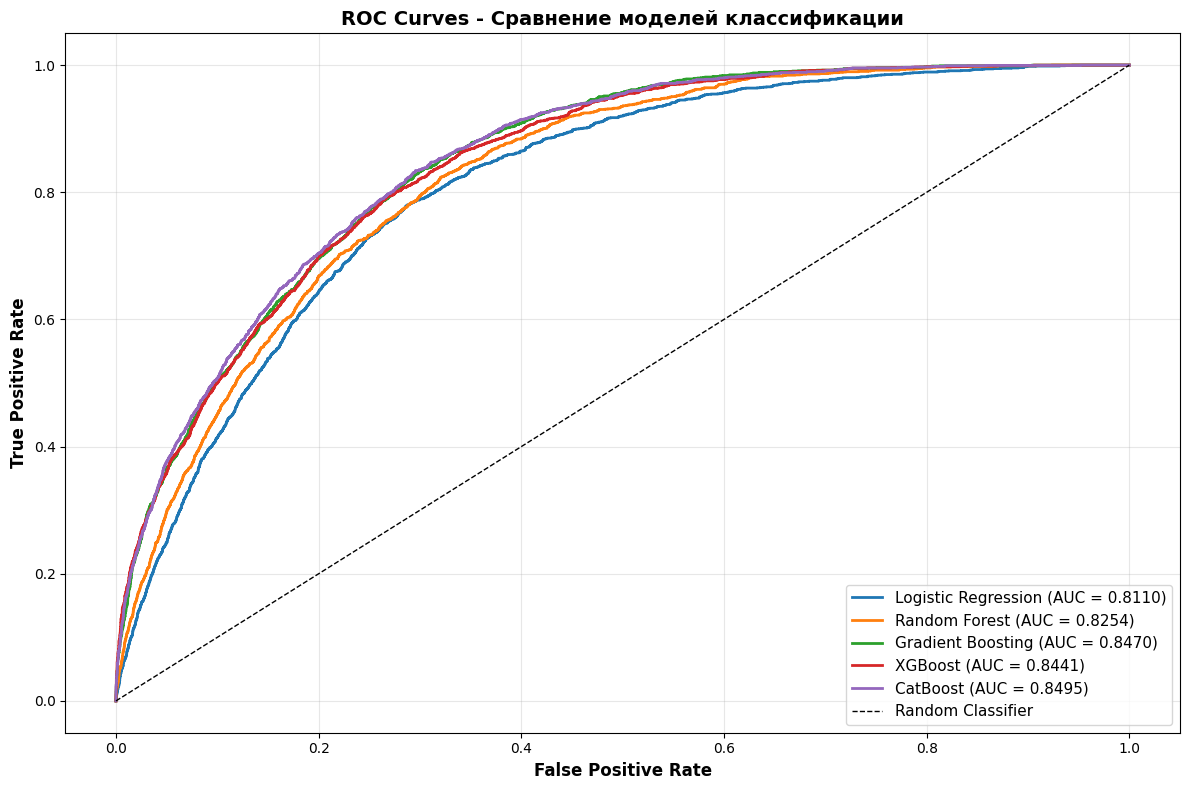


ЯЧЕЙКА 8: АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ
✓ График сохранен: feature_importance.png

Топ-15 важных признаков:
   1. Lapse......................... 0.1668
   2. Policies_in_force............. 0.0731
   3. Days_since_last_renewal....... 0.0724
   4. Payment....................... 0.0562
   5. Contract_age.................. 0.0530
   6. Days_since_lapse.............. 0.0528
   7. N_doors....................... 0.0426
   8. Has_lapse..................... 0.0387
   9. Premium....................... 0.0316
  10. Max_policies.................. 0.0304
  11. Seniority..................... 0.0274
  12. Type_risk..................... 0.0272
  13. Weight........................ 0.0265
  14. Cylinder_capacity............. 0.0263
  15. Length........................ 0.0263


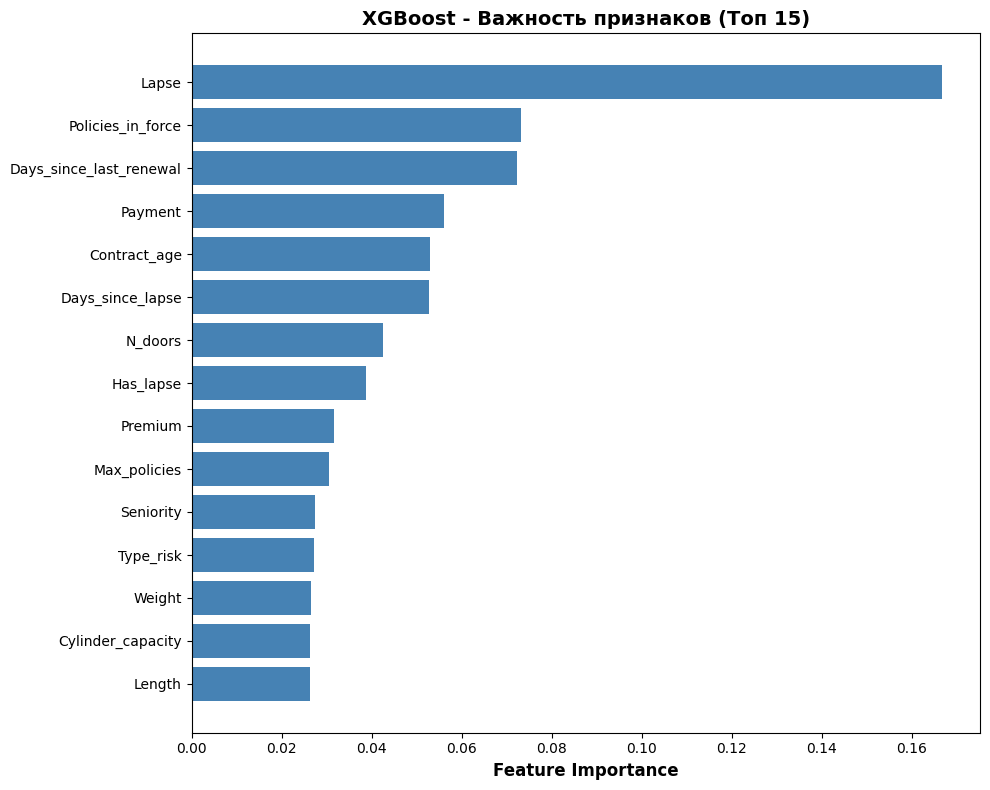

In [182]:
cell_6_cross_validation()
cell_7_plot_roc_curves()
cell_8_plot_feature_importance()



ЯЧЕЙКА 8: АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ
✓ График сохранен: feature_importance.png

Топ-15 важных признаков:
   1. Lapse......................... 0.1668
   2. Policies_in_force............. 0.0731
   3. Days_since_last_renewal....... 0.0724
   4. Payment....................... 0.0562
   5. Contract_age.................. 0.0530
   6. Days_since_lapse.............. 0.0528
   7. N_doors....................... 0.0426
   8. Has_lapse..................... 0.0387
   9. Premium....................... 0.0316
  10. Max_policies.................. 0.0304
  11. Seniority..................... 0.0274
  12. Type_risk..................... 0.0272
  13. Weight........................ 0.0265
  14. Cylinder_capacity............. 0.0263
  15. Length........................ 0.0263
  16. Second_driver................. 0.0260
  17. Year_matriculation............ 0.0260
  18. Type_fuel..................... 0.0257
  19. Value_vehicle................. 0.0256
  20. Area.......................... 0.0252
  21. Age......

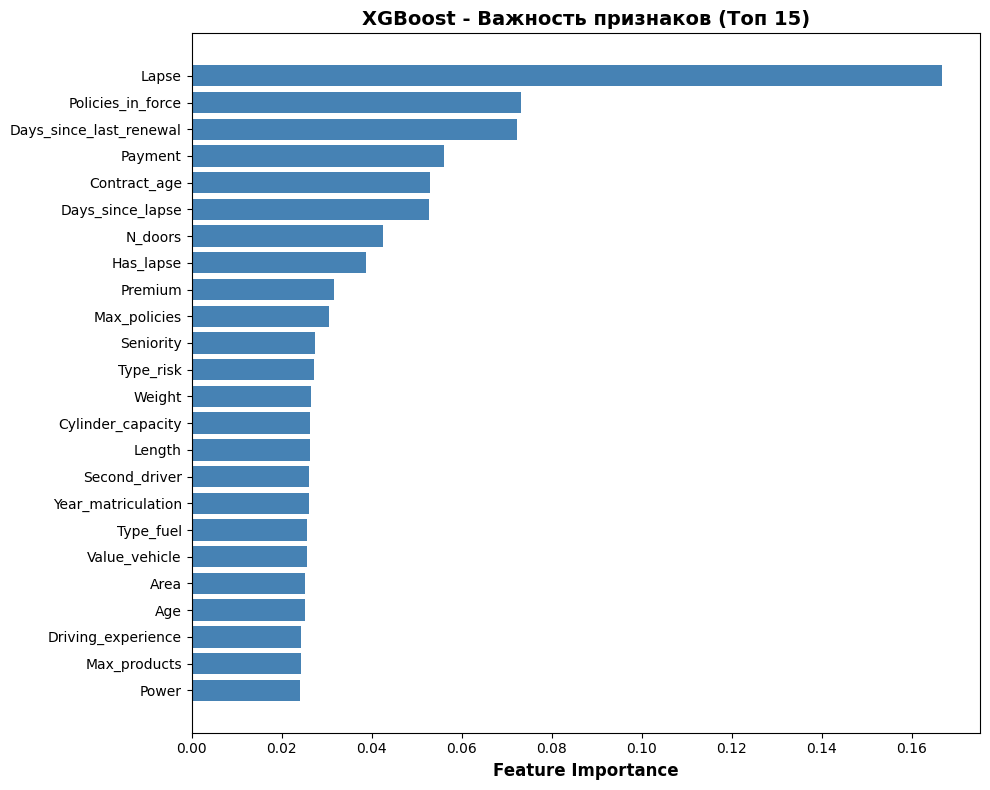


ЯЧЕЙКА 9 (НОВАЯ): ENSEMBLE - XGBOOST + CATBOOST ⭐⭐⭐

📊 Получение предсказаний из обеих моделей...
✓ XGBoost вероятности: min=0.0000, max=0.9992, mean=0.1583
✓ CatBoost вероятности: min=0.0000, max=0.9931, mean=0.2280

----------------------------------------------------------------------
СПОСОБ 1: СРЕДНЕЕ (Average Ensemble)
----------------------------------------------------------------------
📈 Результаты Ensemble Average:
  ROC-AUC:   0.8525
  F1-Score:  0.4181
  Precision: 0.3657
  Recall:    0.4879

----------------------------------------------------------------------
СПОСОБ 2: ВЗВЕШЕННОЕ СРЕДНЕЕ (Weighted Average Ensemble)
----------------------------------------------------------------------
📈 Результаты Ensemble Weighted (XGB=0.5, CAT=0.5):
  ROC-AUC:   0.8525
  F1-Score:  0.4181
  Precision: 0.3657
  Recall:    0.4879

----------------------------------------------------------------------
СПОСОБ 3: МАКСИМУМ (Maximum Ensemble)
--------------------------------------------------

{'Ensemble_Average': {'roc_auc': 0.8525046208109767,
  'f1': 0.418062327750689,
  'precision': 0.36572700296735905,
  'recall': 0.48787728847105394},
 'Ensemble_Weighted': {'roc_auc': 0.8525046208109767,
  'f1': 0.418062327750689,
  'precision': 0.36572700296735905,
  'recall': 0.48787728847105394},
 'Ensemble_Max': {'roc_auc': 0.8527393224987811,
  'f1': 0.4134680134680135,
  'precision': 0.3133452411329421,
  'recall': 0.607619990103909}}

In [184]:
cell_8_plot_feature_importance()
cell_9_ensemble_xgb_catboost()  


ЯЧЕЙКА 10: ROC-КРИВЫЕ ВСЕХ МОДЕЛЕЙ + ENSEMBLE

📊 График 1: Индивидуальные модели
  ✓ Logistic Regression: 0.8110
  ✓ Random Forest: 0.8254
  ✓ Gradient Boosting: 0.8470
  ✓ XGBoost: 0.8441
  ✓ CatBoost: 0.8495

📊 График 2: XGBoost + CatBoost + Ensemble
  ✓ XGBoost: 0.8441
  ✓ CatBoost: 0.8495
  ✓ Ensemble_Average: 0.8525
  ✓ Ensemble_Weighted: 0.8525
  ✓ Ensemble_Max: 0.8527

✓ График сохранен: roc_curves_with_ensemble.png


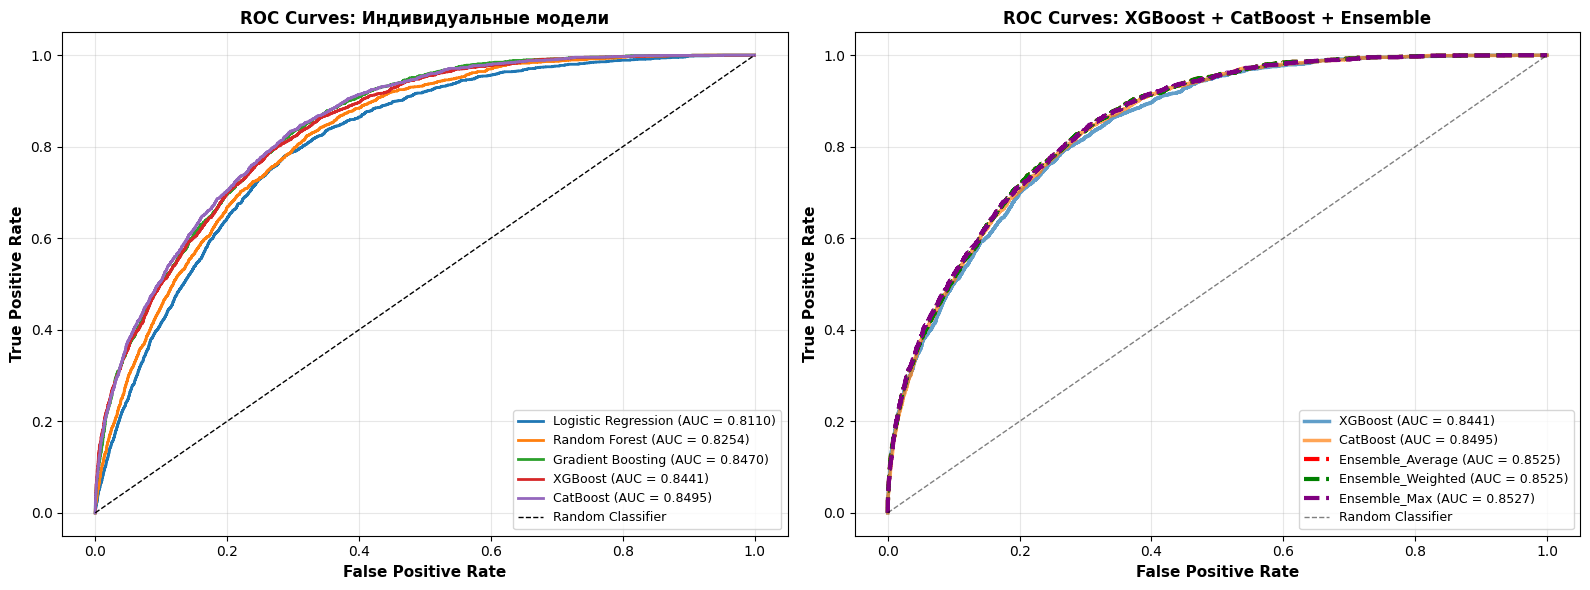


ЯЧЕЙКА 12: ИТОГОВАЯ СВОДКА

🏆 ЛУЧШАЯ ИНДИВИДУАЛЬНАЯ МОДЕЛЬ: CatBoost
   ROC-AUC: 0.8495
   F1-Score: 0.4124

⭐⭐⭐ ЛУЧШАЯ ENSEMBLE МОДЕЛЬ: Ensemble_Max
   ROC-AUC: 0.8527
   F1-Score: 0.4135

📈 Улучшение Ensemble vs Лучшей индивидуальной:
   +0.33% (ROC-AUC)

----------------------------------------------------------------------
ВСЕ РЕЗУЛЬТАТЫ:
----------------------------------------------------------------------

Индивидуальные модели:
  CatBoost........................... ROC-AUC: 0.8495
  Gradient Boosting.................. ROC-AUC: 0.8470
  XGBoost............................ ROC-AUC: 0.8441
  Random Forest...................... ROC-AUC: 0.8254
  Logistic Regression................ ROC-AUC: 0.8110

Ensemble модели:
  Ensemble_Max....................... ROC-AUC: 0.8527
  Ensemble_Average................... ROC-AUC: 0.8525
  Ensemble_Weighted.................. ROC-AUC: 0.8525

РЕКОМЕНДАЦИИ:

✓ Используйте CatBoost для production (если нет Ensemble)
✓ Используйте Ensemble_Max для макс

In [185]:

cell_10_plot_all_roc_curves_with_ensemble()
cell_12_final_summary()

In [187]:
cell_5b_check_overfitting_train_scores()

\n======================================================================
ЯЧЕЙКА 5B: ПРОВЕРКА ПЕРЕОБУЧЕНИЯ (Train ROC-AUC)
\n📊 Вычисление Train ROC-AUC для каждой модели:
----------------------------------------------------------------------
  Logistic Regression........... 0.8122
  Random Forest................. 0.8720
  Gradient Boosting............. 1.0000
  XGBoost....................... 0.9999
  CatBoost...................... 0.9939
\n----------------------------------------------------------------------
СРАВНЕНИЕ TRAIN VS TEST ROC-AUC:
----------------------------------------------------------------------
\nLogistic Regression:
  Train ROC-AUC: 0.8122
  Test ROC-AUC:  0.8110
  Разница:       +0.0012 (+0.1%)
\nRandom Forest:
  Train ROC-AUC: 0.8720
  Test ROC-AUC:  0.8254
  Разница:       +0.0465 (+5.6%)
\nGradient Boosting:
  Train ROC-AUC: 1.0000
  Test ROC-AUC:  0.8470
  Разница:       +0.1530 (+18.1%)
\nXGBoost:
  Train ROC-AUC: 0.9999
  Test ROC-AUC:  0.8441
  Разница:       +

,Model,Train,Test,Diff,Diff%
3,XGBoost,0.999888,0.844086,0.155802,18.458062
2,Gradient Boosting,1.000000,0.846989,0.153011,18.065282
4,CatBoost,0.993901,0.849482,0.144419,17.000810
1,Random Forest,0.871993,0.825445,0.046548,5.639111
0,Logistic Regression,0.812197,0.811039,0.001158,0.142822
